Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   10.1s finished


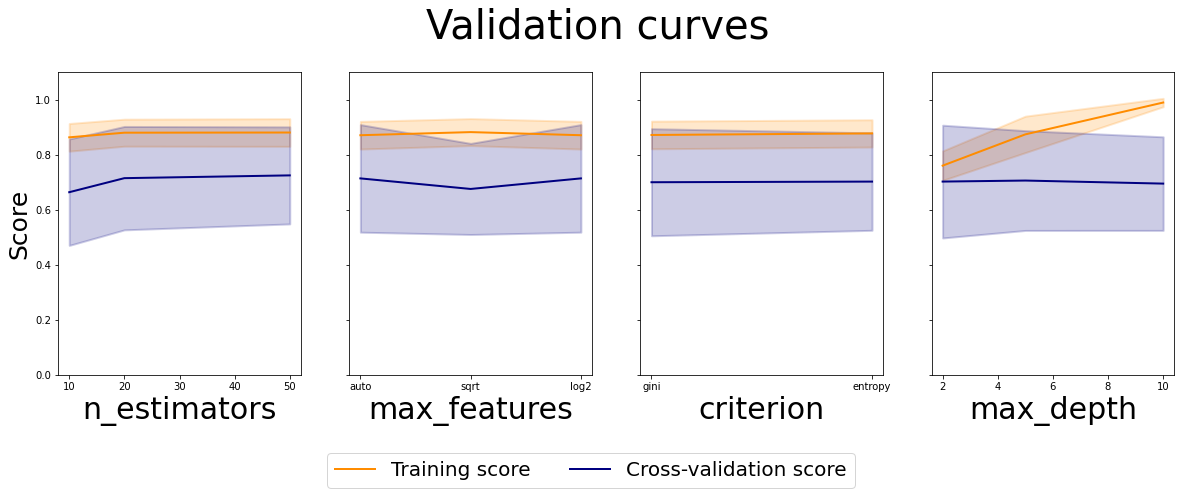

In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
X, y = make_classification(n_samples=1000,  
                           n_features=100, n_informative=2,
                           class_sep=0.5,random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

grid_params = {
   'n_estimators': [10, 20, 50],
   'max_features': ['auto', 'sqrt', 'log2'],
   'criterion': ['gini', 'entropy'],
   'max_depth': [2, 5, 10]
}

gs = GridSearchCV(
    RandomForestClassifier(random_state=42),
    grid_params,
    cv=5,
    verbose=1,
    n_jobs=-1, 
    return_train_score=True # set this for train score
)

gs.fit(X_train, y_train)

import pandas  as pd
df = pd.DataFrame(gs.cv_results_)
results = ['mean_test_score',
           'mean_train_score',
           'std_test_score', 
           'std_train_score']

def pooled_var(stds):
    # https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
    n = 5 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))

fig, axes = plt.subplots(1, len(grid_params), 
                         figsize = (5*len(grid_params), 7),
                         sharey='row')
axes[0].set_ylabel("Score", fontsize=25)


for idx, (param_name, param_range) in enumerate(grid_params.items()):
    grouped_df = df.groupby(f'param_{param_name}')[results]\
        .agg({'mean_train_score': 'mean',
              'mean_test_score': 'mean',
              'std_train_score': pooled_var,
              'std_test_score': pooled_var})

    previous_group = df.groupby(f'param_{param_name}')[results]
    axes[idx].set_xlabel(param_name, fontsize=30)
    axes[idx].set_ylim(0.0, 1.1)
    lw = 2
    axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                color="darkorange", lw=lw)
    axes[idx].fill_between(param_range,grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                    grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                    color="darkorange", lw=lw)
    axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                color="navy", lw=lw)
    axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                    grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                    color="navy", lw=lw)

handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle('Validation curves', fontsize=40)
fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

fig.subplots_adjust(bottom=0.25, top=0.85)  
plt.show()